In [ ]:
#Importando do Google
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Instalar pacote
!pip install category_encoders catboost -q

In [ ]:
#Importando bibliotecas
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import seaborn as sns
import sklearn.metrics as m
from category_encoders import TargetEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score
from sklearn.metrics import make_scorer
specificity = make_scorer(recall_score, pos_label=0)
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc, confusion_matrix, recall_score,classification_report,accuracy_score,precision_score,f1_score,matthews_corrcoef
import pickle

In [ ]:
#Lendo dataframe
df = pd.read_csv('/content/drive/MyDrive/trabalhos/Prediçao Mort Cancer Mato Groso/Banco_Internacao.csv', sep=';').drop(['Sexo','ProcedimentoGrupo'], axis=1)

In [ ]:
#Lendo dataframe (Audencio)
df = pd.read_csv('Banco_Internacao.csv', sep=';').drop(['Sexo','ProcedimentoGrupo'], axis=1)

In [ ]:
#Visualizando dataframe
df.head()

,DiasDePermanencia,NumeroInternacoes,ValorTotal,AnoInternacao,CaraterInternacao,Complexidade,DiagnosticoPrincipal,Especialidade,FoiAObito,Gestao,HospitalNome,Idade,MunicipioResidencia,RacaCor,Regime,TeveDiariasUTI
0,3,1,"467,66",2011,Eletiva,Media complexidade,Endocervix,Clinica Cirurgica,Nao,Municipal plena assist.,ASSOCIACAO MATOGROSSENSE DE COMBATE AO CANCER ...,46,CUIABA,*Nao informado,Privado,Nao
1,1,1,"45,93",2011,Eletiva,Media complexidade,Lesao invasiva,Clinica medica,Sim,Municipal plena assist.,HOSPITAL E PRONTO SOCORRO MUNICIPAL DE CUIABA,45,CUIABA,*Nao informado,Publico,Nao
2,5,1,"658,03",2011,Eletiva,Media complexidade,Nao especificado,Clinica Cirurgica,Nao,Municipal plena assist.,ASSOCIACAO MATOGROSSENSE DE COMBATE AO CANCER ...,45,PONTES E LACERDA,*Nao informado,Privado,Nao
3,2,1,"1216,84",2011,Urg/Emerg (Hosp Referꮣia),Alta complexidade,Ectocervix,Clinica Cirurgica,Nao,Municipal plena assist.,SOCIEDADE BENEFICENTE SANTA CASA DE MISERICORD...,40,VARZEA GRANDE,Parda,Privado,Nao
4,14,1,1100,2011,Urg/Emerg (Hosp Referꮣia),Alta complexidade,Nao especificado,Clinica medica,Nao,Municipal plena assist.,ASSOCIACAO MATOGROSSENSE DE COMBATE AO CANCER ...,34,SANTA HELENA,*Nao informado,Privado,Nao


In [ ]:
df.shape

(3976, 16)

In [ ]:
df.columns

Index(['DiasDePermanencia', 'NumeroInternacoes', 'ValorTotal', 'AnoInternacao',
       'CaraterInternacao', 'Complexidade', 'DiagnosticoPrincipal',
       'Especialidade', 'FoiAObito', 'Gestao', 'HospitalNome', 'Idade',
       'MunicipioResidencia', 'RacaCor', 'Regime', 'TeveDiariasUTI'],
      dtype='object')

In [ ]:
cols_num = ['DiasDePermanencia', 'NumeroInternacoes', 'ValorTotal','Idade']
cols_cat = ['AnoInternacao',
       'CaraterInternacao', 'Complexidade', 'DiagnosticoPrincipal',
       'Especialidade', 'FoiAObito', 'Gestao', 'HospitalNome',
       'MunicipioResidencia', 'RacaCor', 'Regime',
       'TeveDiariasUTI']

In [ ]:
data = df.loc[:,cols_num + cols_cat]

In [ ]:
data['ValorTotal']=data['ValorTotal'].str.replace(',','.')

In [ ]:
data['ValorTotal']=data['ValorTotal'].astype(float)

In [ ]:
data.columns

Index(['DiasDePermanencia', 'NumeroInternacoes', 'ValorTotal', 'Idade',
       'AnoInternacao', 'CaraterInternacao', 'Complexidade',
       'DiagnosticoPrincipal', 'Especialidade', 'FoiAObito', 'Gestao',
       'HospitalNome', 'MunicipioResidencia', 'RacaCor', 'Regime',
       'TeveDiariasUTI'],
      dtype='object')

In [ ]:
data.FoiAObito.value_counts()

,count
FoiAObito,
Nao,3584
Sim,392


In [ ]:
# Listas de colunas para cada tipo de encoding
label_encoding_cols = ['AnoInternacao', 'CaraterInternacao', 'Complexidade', 'DiagnosticoPrincipal', 'Especialidade',
                       'Gestao','RacaCor','Regime','TeveDiariasUTI','FoiAObito']
target_encoding_cols = ['HospitalNome', 'MunicipioResidencia','DiagnosticoPrincipal']

# Aplicando Label Encoding nas colunas especificadas
label_encoder = LabelEncoder()
for col in label_encoding_cols:
    data[col] = label_encoder.fit_transform(data[col])

# Aplicando Target Encoding nas colunas especificadas
target_encoder = TargetEncoder(cols=target_encoding_cols)
data[target_encoding_cols] = target_encoder.fit_transform(data[target_encoding_cols], data['FoiAObito'])

# Visualizando as primeiras linhas para verificar os resultados
data.head()

,DiasDePermanencia,NumeroInternacoes,ValorTotal,Idade,AnoInternacao,CaraterInternacao,Complexidade,DiagnosticoPrincipal,Especialidade,FoiAObito,Gestao,HospitalNome,MunicipioResidencia,RacaCor,Regime,TeveDiariasUTI
0,3,1,467.66,46,0,0,1,0.024976,0,0,1,0.149837,0.113150,0,0,0
1,1,1,45.93,45,0,0,1,0.145374,1,1,1,0.219330,0.113150,0,1,0
2,5,1,658.03,45,0,0,1,0.139294,0,0,1,0.149837,0.038081,0,0,0
3,2,1,1216.84,40,0,1,0,0.010811,0,0,1,0.160494,0.137845,4,0,0
4,14,1,1100.00,34,0,1,0,0.139294,1,0,1,0.149837,0.155532,0,0,0


In [ ]:
# Separando a variável alvo e as features
X = data.drop(columns=['FoiAObito'])
y = data['FoiAObito']

In [ ]:
# Dicionário de mapeamento para inglês
mapping = {
    "DiasDePermanencia": "Days hospitalized",
    "NumeroInternacoes": "Number of hospitalizations",
    "ValorTotal": "Cost of hospitalization",
    "Idade": "Age",
    "AnoInternacao": "Hospitalization period",
    "CaraterInternacao": "Admission type",
    "Complexidade": "Service complexity",
    "DiagnosticoPrincipal": "Type of cancer by topography",
    "Especialidade": "Medical procedure",
    "FoiAObito": "Death",
    "Gestao": "Management",
    "HospitalNome": "Hospital",
    "MunicipioResidencia": "City of residence",
    "RacaCor": "Race/color",
    "Regime": "Regimen",
    "TeveDiariasUTI": "ICU admission"
}

# Renomeia as colunas do DataFrame X_test
X = X.rename(columns=mapping)

In [ ]:
X.columns=['Days hospitalized', 'Number of hospitalization', 'Cost of hospitalization', 'Age',
       'Hospitalization period', 'Admission Type', 'Service complexity', 'Type of cancer by topography',
       'Medical procedure', 'Management', 'Hospital', 'City of residence', 'Race/Color', 'Regimen', 'ICU admission']

In [ ]:
# Separar as colunas categóricas e numéricas
numeric_cols = ['Days hospitalized', 'Number of hospitalization', 'Cost of hospitalization', 'Age']
categorical_cols = ['Hospitalization period', 'Admission Type', 'Service complexity', 'Type of cancer by topography',
       'Medical procedure', 'Management', 'Hospital', 'City of residence', 'Race/Color', 'Regimen', 'ICU admission']

# Tabela descritiva das variáveis numéricas
numeric_summary = X[numeric_cols].describe()

# Tabela descritiva das variáveis categóricas (frequências)
categorical_summary = X[categorical_cols].apply(lambda x: x.value_counts())

# Matriz de Correlação das Variáveis Numéricas
correlation_matrix_num = X[numeric_cols].corr()

# Matriz de Correlação das Variáveis Categóricas
correlation_matrix_cat = X[categorical_cols].corr()

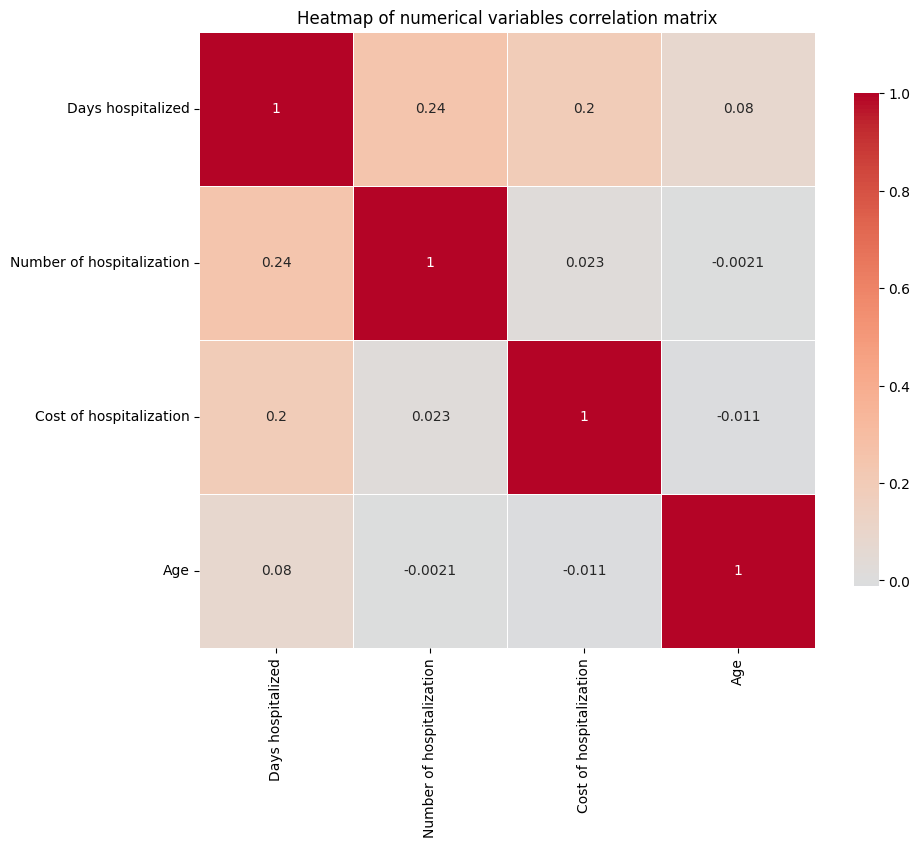

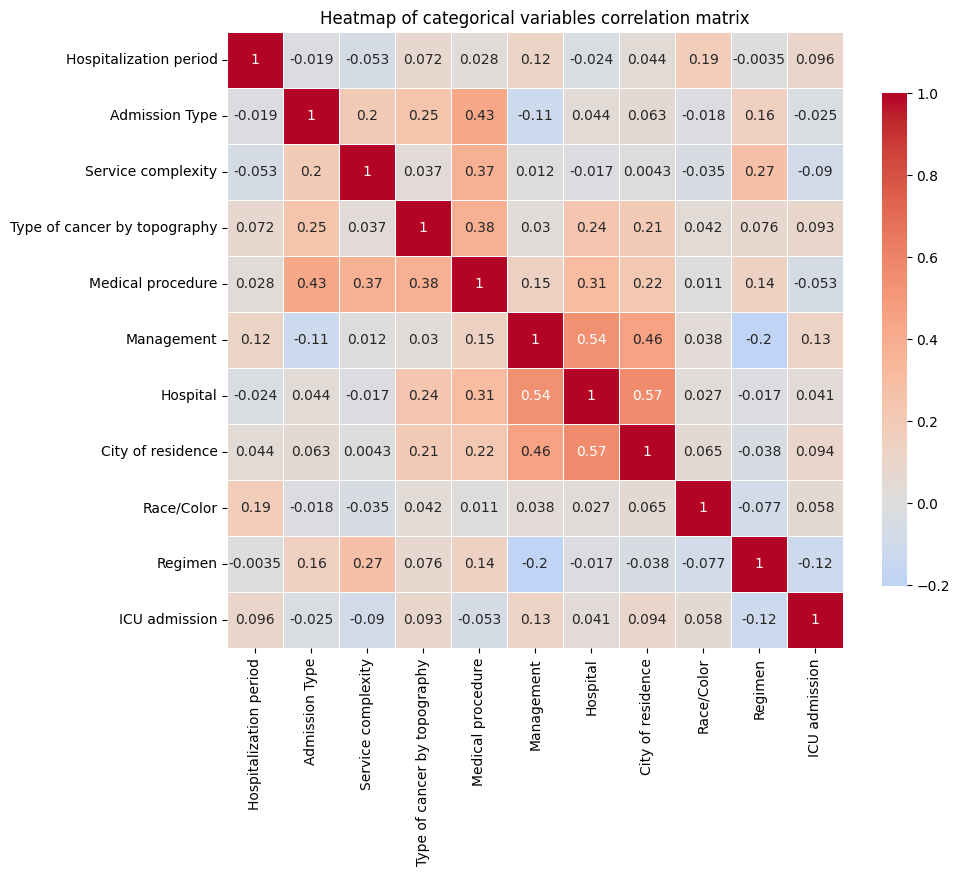

In [ ]:
# Plotando o heatmap da matriz de correlação numérica
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_num, annot=True, cmap='coolwarm', center=0, square=True, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title("Heatmap of numerical variables correlation matrix")
#plt.savefig("/content/drive/MyDrive/trabalhos/Prediçao Mort Cancer Mato Groso/heatmap_num_300dpi.png", dpi=300)
plt.show()

# Plotando o heatmap da matriz de correlação categórica
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_cat, annot=True, cmap='coolwarm', center=0, square=True, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title("Heatmap of categorical variables correlation matrix")
#plt.savefig("/content/drive/MyDrive/trabalhos/Prediçao Mort Cancer Mato Groso/heatmap_cat_300dpi.png", dpi=300)
plt.show()

In [ ]:
# Dividindo em treino e teste, mantendo a proporção da classe 'FoiAObito'
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Verificando as proporções
print("Proporção de classes no treino:")
print(y_train.value_counts(normalize=True))
print("\nProporção de classes no teste:")
print(y_test.value_counts(normalize=True))

Proporção de classes no treino:
FoiAObito
0    0.901258
1    0.098742
Name: proportion, dtype: float64

Proporção de classes no teste:
FoiAObito
0    0.90201
1    0.09799
Name: proportion, dtype: float64


In [ ]:
# Dividindo em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Aplicando SMOTE no conjunto de treino
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [ ]:
# Definindo os modelos e os hiperparâmetros para Grid Search
models = {
    'LogisticRegression': (LogisticRegression(max_iter=1000), {
        'C': [0.1, 1, 10]
    }),
    'RandomForest': (RandomForestClassifier(random_state=42), {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5]
    }),
    'CatBoost': (CatBoostClassifier(random_state=42, silent=True), {
        'depth': [4, 6, 8],
        'learning_rate': [0.01, 0.1, 0.3],
        'iterations': [100, 200]
    }),
    'LGBM': (LGBMClassifier(random_state=42), {
        'num_leaves': [31, 50],
        'learning_rate': [0.01, 0.1, 0.3],
        'n_estimators': [100, 200]
    }),
    'XGBoost': (

      ier(random_state=42, use_label_encoder=False, eval_metric='logloss'), {
        'max_depth': [4, 6, 8],
        'learning_rate': [0.01, 0.1, 0.3],
        'n_estimators': [100, 200]
    })
}

In [ ]:
# Configuração da validação cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Dicionário para armazenar os melhores modelos
best_models = {}

# Loop para rodar GridSearchCV para cada modelo e encontrar os melhores hiperparâmetros
for model_name, (model, params) in models.items():
    grid_search = GridSearchCV(model, param_grid=params, cv=cv, scoring='roc_auc', n_jobs=-1, verbose=1)
    grid_search.fit(X_train_smote, y_train_smote)
    best_models[model_name] = grid_search.best_estimator_
    print(f"Melhores hiperparâmetros para {model_name}: {grid_search.best_params_}")

Fitting 5 folds for each of 3 candidates, totalling 15 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Melhores hiperparâmetros para LogisticRegression: {'C': 1}
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Melhores hiperparâmetros para RandomForest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Fitting 5 folds for each of 18 candidates, totalling 90 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Melhores hiperparâmetros para CatBoost: {'depth': 8, 'iterations': 200, 'learning_rate': 0.3}
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2866, number of negative: 2866
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000773 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1181
[LightGBM] [Info] Number of data points in the train set: 5732, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Melhores hiperparâmetros para LGBM: {'learning_rate': 0.1, 'n_estimators': 200, 'num_leaves': 50}
Fitting 5 folds for each of 18 candidates, totalling 90 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:51:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Melhores hiperparâmetros para XGBoost: {'learning_rate': 0.3, 'max_depth': 6, 'n_estimators': 100}


In [ ]:
# Avaliação dos modelos no conjunto de teste
for model_name, model in best_models.items():
    y_pred = model.predict(X_test)
    print(f"\nRelatório de classificação para {model_name} no conjunto de teste:")
    print(classification_report(y_test, y_pred))


Relatório de classificação para LogisticRegression no conjunto de teste:
              precision    recall  f1-score   support

           0       0.97      0.79      0.87       718
           1       0.29      0.81      0.43        78

    accuracy                           0.79       796
   macro avg       0.63      0.80      0.65       796
weighted avg       0.91      0.79      0.83       796


Relatório de classificação para RandomForest no conjunto de teste:
              precision    recall  f1-score   support

           0       0.93      0.94      0.93       718
           1       0.35      0.31      0.33        78

    accuracy                           0.88       796
   macro avg       0.64      0.62      0.63       796
weighted avg       0.87      0.88      0.87       796


Relatório de classificação para CatBoost no conjunto de teste:
              precision    recall  f1-score   support

           0       0.93      0.94      0.93       718
           1       0.38      0.

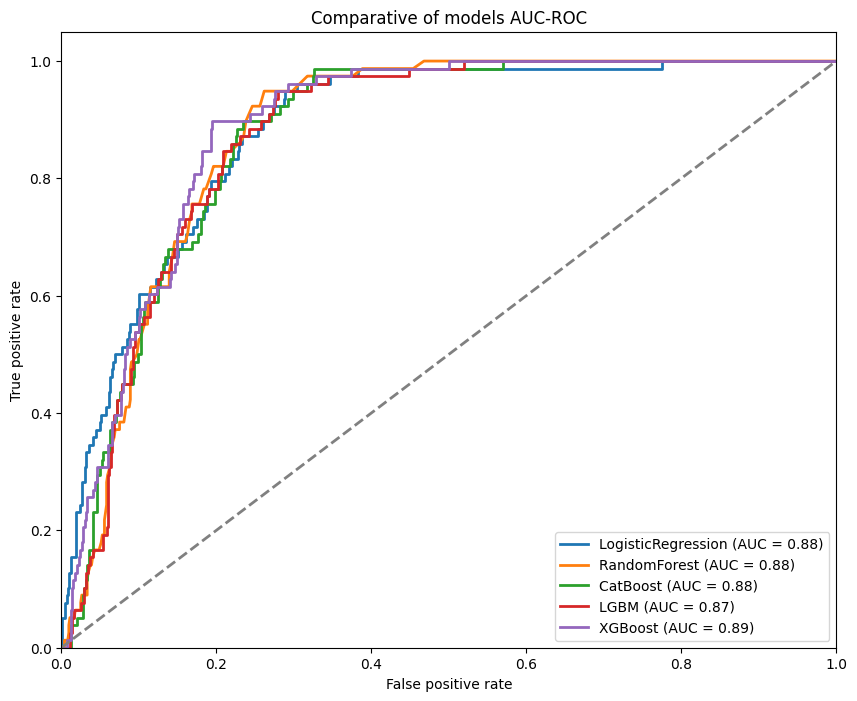

In [ ]:
# Avaliação dos modelos no conjunto de teste
plt.figure(figsize=(10, 8))

for model_name, model in best_models.items():
    # Obtenção das probabilidades de predição
    y_proba = model.predict_proba(X_test)[:, 1]

    # Curva ROC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    # Plot da curva ROC para cada modelo
    plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')

# Linha diagonal de referência
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)

# Configurações do gráfico
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Comparative of models AUC-ROC')
plt.legend(loc="lower right")
#plt.grid(alpha=0.3)
#plt.savefig(f"/content/drive/MyDrive/trabalhos/Prediçao Mort Cancer Mato Groso/roc_auc_models_300dpi.png", dpi=300)
plt.show()

Modelo com melhor AUC no teste: XGBoost


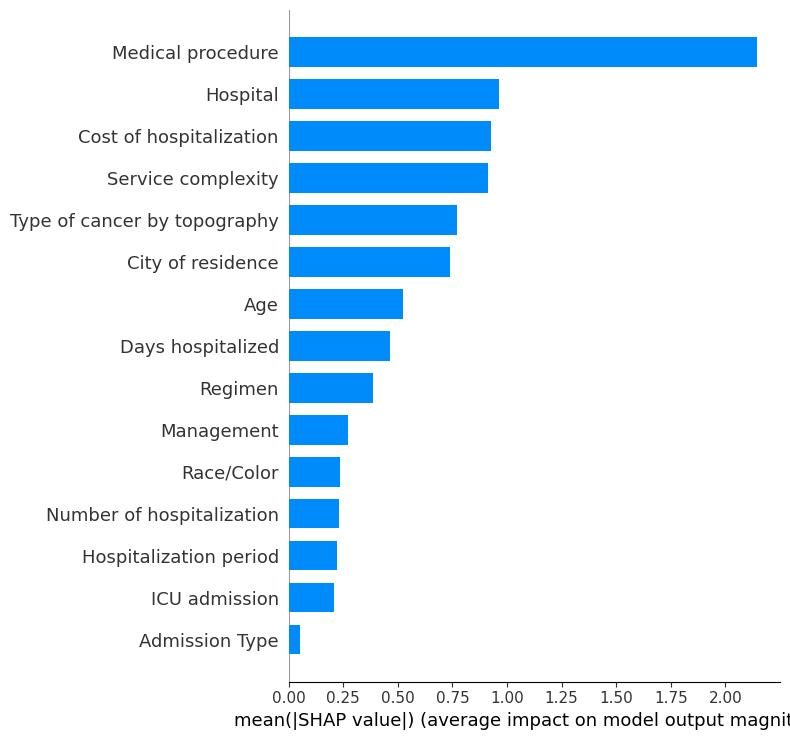

In [ ]:
import shap
import numpy as np
from sklearn.metrics import roc_auc_score

# Identificar o melhor modelo com base na métrica AUC no conjunto de teste
best_model_name = max(best_models, key=lambda name: roc_auc_score(y_test, best_models[name].predict_proba(X_test)[:, 1]))
best_model = best_models[best_model_name]
print(f"Modelo com melhor AUC no teste: {best_model_name}")

# Criar o interpretador SHAP com amostras de teste
explainer = shap.TreeExplainer(best_model) if best_model_name in ['Random Forest', 'CatBoost', 'LGBM', 'XGBoost'] else shap.KernelExplainer(best_model.predict_proba, X_test)
shap_values = explainer.shap_values(X_test)

# Visualização dos valores SHAP para a classe positiva
if isinstance(shap_values, list):  # Caso de múltiplas classes (e.g., árvore de decisão)
    shap_values_class = shap_values[1]  # Classe positiva
else:
    shap_values_class = shap_values

# Gráfico de Importância das Variáveis
shap.summary_plot(shap_values_class, X_test, plot_type="bar")

# Salva o gráfico com 300 DPI
#plt.savefig("/content/drive/MyDrive/trabalhos/Prediçao Mort Cancer Mato Groso/shap_bar_300dpi_en.png", dpi=300, bbox_inches='tight')
plt.show()  # Mostra o gráfico apenas se necessário

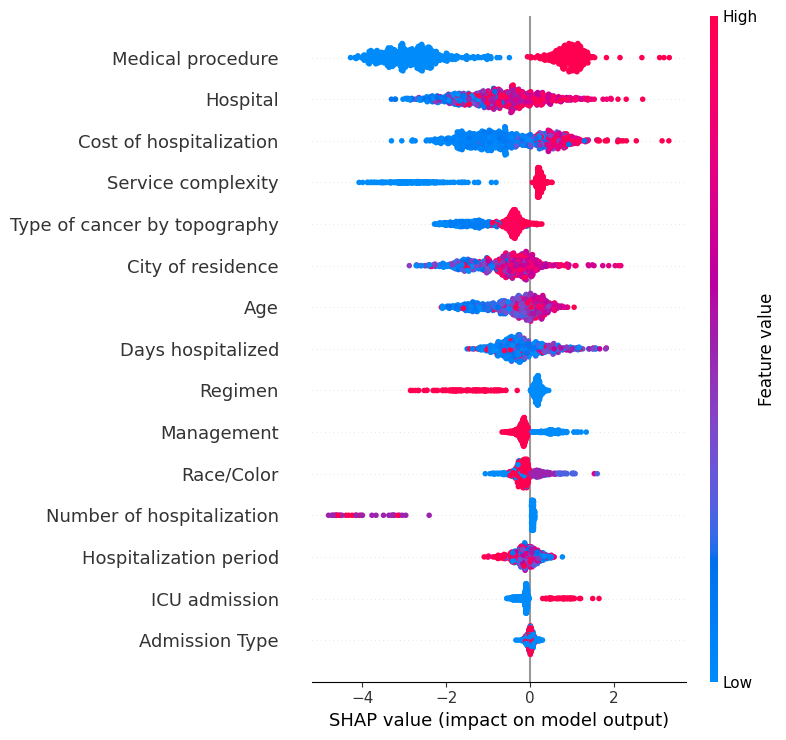

In [ ]:
# Gráfico de Beeswarm para uma visão detalhada
shap.summary_plot(shap_values_class, X_test)

# Salva o gráfico com 300 DPI
#plt.savefig("/content/drive/MyDrive/trabalhos/Prediçao Mort Cancer Mato Groso/shap_bsw_300dpi_en.png", dpi=300, bbox_inches='tight')
plt.show()  # Mostra o gráfico apenas se necessário

In [ ]:
import shap
import numpy as np
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# Assuming 'best_models', 'X_test', and 'y_test' are already defined and loaded

# Identify the best model based on the AUC metric on the test set
best_model_name = max(best_models, key=lambda name: roc_auc_score(y_test, best_models[name].predict_proba(X_test)[:, 1]))
best_model = best_models[best_model_name]
print(f"Modelo com melhor AUC no teste: {best_model_name}")

# Create a SHAP explainer based on the best model
if best_model_name in ['Random Forest', 'CatBoost', 'LGBM', 'XGBoost']:
    explainer = shap.TreeExplainer(best_model)
else:
    explainer = shap.KernelExplainer(best_model.predict_proba, X_test)

# Compute SHAP values for the test data
shap_values = explainer.shap_values(X_test)

# Choose a specific prediction to visualize, e.g., the first instance in the test set
index_to_explain = 0  # Change this index to target different test instances

# Determine the appropriate expected value
if isinstance(explainer.expected_value, np.ndarray):
    expected_value = explainer.expected_value[1]  # Use expected value for the positive class
else:
    expected_value = explainer.expected_value  # Use scalar expected value

# Initialize JavaScript visualization
shap.initjs()

# Create a force plot for the selected instance
force_plot = shap.force_plot(
    expected_value,  # Adjusted to handle scalar expected value
    shap_values[1][index_to_explain] if isinstance(shap_values, list) else shap_values[index_to_explain],
    X_test.iloc[index_to_explain, :]  # Feature values for the selected instance
)

force_plot  # This will display the plot inline if using Jupyter or a similar environment



Modelo com melhor AUC no teste: XGBoost


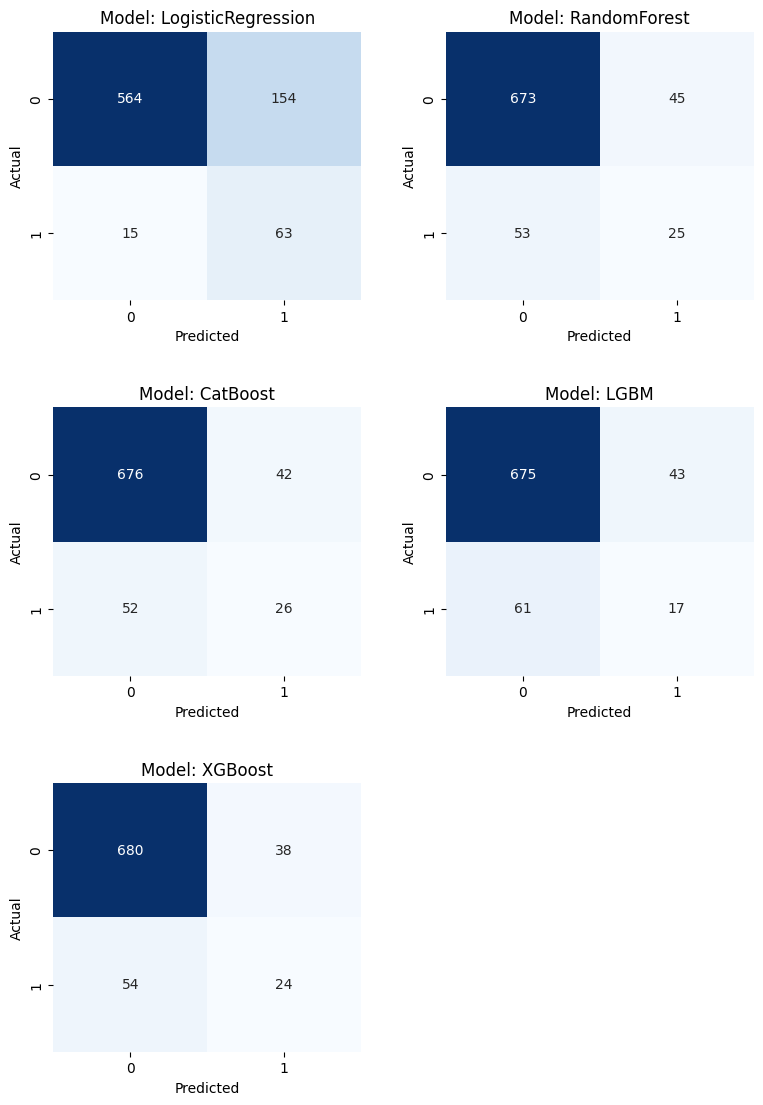

In [ ]:

#Matriz de confusao
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Set the figure size to A4
plt.figure(figsize=(8.27, 11.69))

# Loop through the best models to calculate metrics and plot confusion matrices
for idx, (model_name, model) in enumerate(best_models.items(), start=1):
    # Predict probabilities for the positive class
    y_proba = model.predict_proba(X_test)[:, 1]

    # Calculate binary predictions using a fixed threshold of 0.5
    y_pred_0_5 = (y_proba >= 0.5).astype(int)

    # Confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred_0_5)

    # Subplot for each confusion matrix
    plt.subplot(3, 2, idx)  # Adjust based on the number of models
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Model: {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

    if idx == 5:
        break  # Exit the loop after the fifth model

# Adjust spacing between subplots
plt.tight_layout(pad=3.0)

# Display the figure
plt.show()
